In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from random import random
import copy

In [2]:
# community class definition
class community:
    def __init__(self, member, prob):
        self.member = member
        self.prob = prob

In [3]:
# AGM 用于生成网络的一种模型
def AGM(nodes, communities):
    # create an empty graph
    G = nx.Graph()
    # add nodes to this graph
    G.add_nodes_from(nodes)
    
    # generate links within comminities
    for c in communities:
        for nodePairs in combinations(c.member, 2):
            if random() <= c.prob:
                G.add_edge(nodePairs[0], nodePairs[1])
    return G

In [4]:
nodes = range(6)
communities = [community([0,1,2], 1),
              community([3,4,5], 1),
              community([0,5], 1),
              community([2,3], 1)]

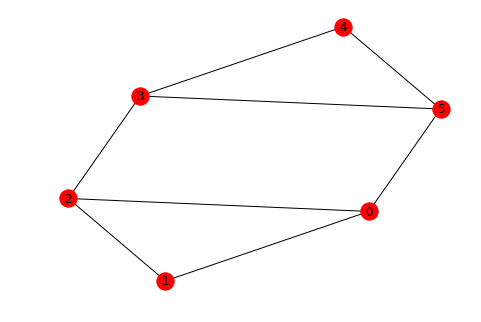

In [5]:
G = AGM(nodes, communities)
nx.draw(G, with_labels=True)

In [8]:
for i in G.neighbors([0,1]):
    print(i)

TypeError: unhashable type: 'list'

In [21]:
G.edges()

EdgeView([(0, 1), (0, 2), (0, 5), (1, 2), (2, 3), (3, 4), (3, 5), (4, 5)])

In [105]:
list(G.nodes())

[0, 1, 2, 3, 4, 5]

In [93]:
for node in G.degree():
    print(node)

(0, 3)
(1, 2)
(2, 3)
(3, 3)
(4, 2)
(5, 3)


In [64]:
for item in G.edges():
    print('item: ', item)
    print(item[0])
    print(type(item[0]))

item:  (0, 1)
0
<class 'int'>
item:  (0, 2)
0
<class 'int'>
item:  (0, 5)
0
<class 'int'>
item:  (1, 2)
1
<class 'int'>
item:  (2, 3)
2
<class 'int'>
item:  (3, 4)
3
<class 'int'>
item:  (3, 5)
3
<class 'int'>
item:  (4, 5)
4
<class 'int'>


In [71]:
len([i for i in G.neighbors(0)])

3

In [67]:
for i in G.neighbors(0):
    print(i)

1
2
5


In [22]:
# intersections - 相交点
for edge in G.edges():
    print(edge)
    print(len(set(edge).intersection(set(nodes))))

(0, 1)
2
(0, 2)
2
(0, 5)
2
(1, 2)
2
(2, 3)
2
(3, 4)
2
(3, 5)
2
(4, 5)
2


In [23]:
print(len(set((0,1)).intersection(set((4,5)))))

0


In [33]:
print(len(set((2,3)).intersection(set((0,1,2)))))

1


In [25]:
# 假设现在有一个聚集A，包括三个节点[0,1,2]，计算该聚集的cut指标：
# cluster measures
class cluster:
    def __init__(self, member, cut=None):
        self.member = member
        self.cut = cut

In [52]:
# graph - 图；nodes - 聚集节点
def clusterCutScore(graph, nodes):
    cutScore = 0 
    for edge in graph.edges():
        if len(set(edge).intersection(set(nodes))) == 1:
            print(edge)
            cutScore += 1
            print('cutScore: ', cutScore)
    return cutScore

In [53]:
clusterA = cluster([0,1,2], clusterCutScore(G, [0,1,2]))
print(clusterA.cut)

(0, 5)
cutScore:  1
(2, 3)
cutScore:  2
2


In [55]:
# Cut值并不是一个非常好的指标，如果包含度为1的节点，
# 那么仅仅由节点一个节点构成的聚类，Cut值为1
# 所以有了如下修改

In [79]:
# 假设现在有一个聚集A，包括三个节点[0,1,2]，计算该聚集的conductance指标：
# conductance: phi(A)=fractextcut(A)min(vol(A),2m−vol(A)) -- 越低越好，防止出现划分单个节点

class cluster:
    def __init__(self, member, cut=None, conductance=None):
        self.member = member
        self.cut = cut
        self.conductance = conductance

In [91]:
def clusterConductanceScore(graph, nodes):
    m = graph.number_of_edges()
#     以下一条错误
#     volA = sum([len([i for i in (graph.neighbors(node) for node in nodes)])])
    volA = 0
    for node in nodes:
        print('node: ', node)
        volA += len([i for i in (graph.neighbors(node))])
        print('volA: ', volA)
    cut = clusterCutScore(graph, nodes)
    return float(cut)/min(volA, 2*m-volA)

In [92]:
nodes = [0,1,2]
clusterA = cluster(nodes, clusterCutScore(G, nodes), clusterConductanceScore(G, nodes))
print('clusterA.conductance:',clusterA.conductance)

(0, 5)
cutScore:  1
(2, 3)
cutScore:  2
node:  0
volA:  3
node:  1
volA:  5
node:  2
volA:  8
(0, 5)
cutScore:  1
(2, 3)
cutScore:  2
clusterA.conductance: 0.25


In [94]:
# define Laplace Matrix - 网络的度矩阵 和 网络的邻接矩阵 之差
def laplacianOfGraph(graph):
    n = graph.number_of_nodes()
    A = nx.to_numpy_matrix(graph)  # adjacency matrix
    D = np.matrix(np.zeros((n,n)))  # degree matrix
    for node_degree in graph.degree():
        node, degree = node_degree
        D[node, node] = degree
    L = D - A
    return L

In [95]:
print(laplacianOfGraph(G))

[[ 3. -1. -1.  0.  0. -1.]
 [-1.  2. -1.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.]
 [ 0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0. -1.  2. -1.]
 [-1.  0.  0. -1. -1.  3.]]


In [108]:
def naiveSpectralClustering(graph):
    L = laplacianOfGraph(graph)
    evals, evecs = np.linalg.eig(L)  # eigenvalue, eigenvector
    values = np.array(evecs[:, 1]).reshape(-1).tolist()
    n = len(values)
    cluster1 = [i for i in range(n) if values[i] <= 0]
    cluster2 = [i for i in range(n) if values[i] > 0]
    return cluster1, cluster2

In [109]:
c1, c2 = naiveSpectralClustering(G)

In [110]:
print(c1)

[0, 1, 2]


In [111]:
print(c2)

[3, 4, 5]
